第一题

In [1]:
import cv2
import numpy as np
import time
def Quantize(img3f,ratio=0.95,colorNums=(12,12,12)):
    clrTmp = [colorNums[0]-0.0001, colorNums[1]-0.0001, colorNums[2]-0.0001]
    w = [colorNums[1] * colorNums[2], colorNums[2], 1]
    height,width = img3f.shape[:2]
    img3f_0,img3f_1,img3f_2 = cv2.split(img3f)
    idx_img3f_0 = (img3f_0 * clrTmp[0] ).astype(np.int32)* w[0]
    idx_img3f_1 = (img3f_1 * clrTmp[1] ).astype(np.int32)* w[1]
    idx_img3f_2 = (img3f_2 * clrTmp[2] ).astype(np.int32)* w[2]
    idx1i = idx_img3f_0 + idx_img3f_1 + idx_img3f_2
    #==================== 统计像素出现频数 ======================
    bincount_pallet = np.bincount(idx1i.reshape(1,-1)[0])
    print('bincount_pallet:',len(bincount_pallet))
    sort_pallet = np.sort(bincount_pallet)
    argsort_pallet = np.argsort(bincount_pallet)
    numpy_pallet = np.vstack((sort_pallet, argsort_pallet))
    numpy_pallet = numpy_pallet[:, np.nonzero(sort_pallet)]
    num = np.swapaxes(numpy_pallet, 0, 1)[0] # 维度交换
    len_num = maxNum = len(num[0]) # 所有颜色值出现频数的排序（从小到大）
    maxDropNum = int(np.round(height * width * (1 - ratio))) # 设置删除最大元素阈值
    sum_pallet = np.add.accumulate(num[0])
    arg_sum_pallett = np.argwhere(sum_pallet >= maxDropNum)[0][0] # 前95%的颜色值数量
    maxNum = maxNum - arg_sum_pallett # 后5%的颜色值数量
    num_values = num[1][::-1] # 所有高频次颜色值的位置（颜色值降序）
    maxNum = 256 if maxNum > 256 else maxNum
    if maxNum <= 10:
        maxNum = 10 if len(num) > 10 else len(num)
    color3i_init0 = (num_values / w[0]).astype(np.int32)
    color3i_init1 = (num_values % w[0]/w[1]).astype(np.int32)
    color3i_init2 = (num_values % w[1]).astype(np.int32)
    color3i = np.array([color3i_init0,color3i_init1,color3i_init2]).T
    #=========================计算像素距离==============================
    zero2maxNum = color3i[:maxNum] # 5%的颜色值数量部分
    maxNum2len_Num = color3i[maxNum:] # 95%的颜色值数量部分
    temp_matrix = np.zeros((len_num-maxNum,maxNum),dtype=np.int32)
    for i,single in enumerate(maxNum2len_Num): #分别求：95%的颜色值与5%的颜色值的距离
        temp_matrix[i] = np.sum(np.square(single-zero2maxNum),axis=1)
    arg_min = np.argmin(temp_matrix, axis=1)
    replaceable_colors = num_values[arg_min] # 通过索引获取5%的颜色值中距离95%的颜色值最近的颜色值
    pallet = dict(zip(num_values[:maxNum], range(maxNum)))
    for num_value,index_dist in zip(num_values[maxNum:],replaceable_colors):
        pallet[num_value] = pallet[index_dist]
    #=================================================================
    idx1i_reshape = idx1i.copy().reshape(1,-1)[0]
    idx1i_0 = np.zeros(height * width, dtype=np.int32)
    for i, v in enumerate(idx1i_reshape):
        idx1i_0[i] = pallet[v]
    idx1i = idx1i_0.reshape((height,width))
    color3f = np.zeros((1, maxNum, 3), np.float32)
    colorNum = np.zeros((1, maxNum), np.int32)
    np.add.at(color3f[0], idx1i, img3f)
    np.add.at(colorNum[0], idx1i, 1)
    colorNum_reshape = colorNum.reshape(color3f.shape[1],1)
    color3f[0] /= colorNum_reshape
    return color3f.shape[1],idx1i,color3f,colorNum


bincount_pallet: 1728
Quantize time is : 0.16712236404418945 seconds


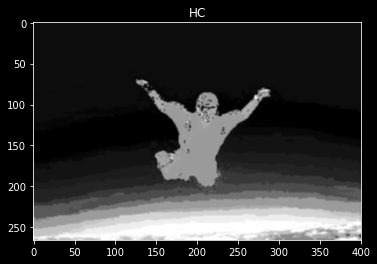

In [2]:
import cv2, time
import numpy as np
from scipy.spatial.distance import pdist, squareform

def GetHC(img_float,delta=0.25):
    t1 = time.time()
    binN, idx1i, binColor3f, colorNums1i = Quantize(img_float)                 # 颜色量化
    t2 = time.time()
    print("Quantize time is :", t2 - t1, 'seconds')
    binColor3f = cv2.cvtColor(binColor3f, cv2.COLOR_BGR2Lab)                   # 颜色空间：BGR2Lab
    weight1f = np.zeros(colorNums1i.shape, np.float32)
    cv2.normalize(colorNums1i.astype(np.float32), weight1f, 1, 0, cv2.NORM_L1) # 相邻色彩相关权重

    binColor3f_reshape = binColor3f.reshape(-1, 3)[:binN]
    similar_dist = squareform(pdist(binColor3f_reshape))
    similar_dist_sort = np.sort(similar_dist)
    similar_dist_argsort = np.argsort(similar_dist)

    weight1f = np.tile(weight1f, (binN, 1))
    color_weight_dist = np.sum(np.multiply(weight1f, similar_dist), axis=1)    # 颜色距离的权重分配

    colorSal = np.zeros((1, binN), np.float64)
    if colorSal.shape[1] < 2:
        return
    tmpNum = int(np.round(binN * delta))                                       # tmpNum 占比0.25的变化的颜色值数量
    n = tmpNum if tmpNum > 2 else 2

    similar_nVal = similar_dist_sort[:, :n]
    totalDist_similar = np.sum(similar_nVal, axis=1)
    every_Dist = np.tile(totalDist_similar[:, np.newaxis], (1, n)) - similar_nVal

    idx = similar_dist_argsort[:, :n]
    val_n = np.take(color_weight_dist,idx)                                    # 获取占比前0.25的颜色权重距离

    valCrnt = np.sum(val_n[:, :n] * every_Dist, axis=1)
    newSal_img = valCrnt / (totalDist_similar * n)
    cv2.normalize(newSal_img, newSal_img, 0, 1, cv2.NORM_MINMAX)              # 归一化
    salHC_img = np.take(newSal_img,idx1i)
    cv2.GaussianBlur(salHC_img, (3, 3), 0, salHC_img)
    cv2.normalize(salHC_img, salHC_img, 0, 1, cv2.NORM_MINMAX)
    return salHC_img


img3_int = cv2.imread("im1.jpg")
img3_float = img3_int.astype(np.float32)
img3_float = img3_float / 255.0

sal = (GetHC(img3_float)*255).astype(np.int32)
import matplotlib.pyplot as plt
plt.figure()
plt.title('HC')
plt.imshow(sal,cmap='gray')
plt.show()

bincount_pallet: 1728
Quantize time is : 0.26003503799438477 seconds


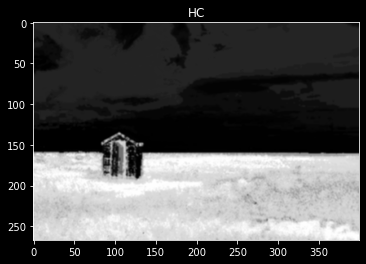

In [3]:
img3_int = cv2.imread("im2.jpg")
img3_float = img3_int.astype(np.float32)
img3_float = img3_float / 255.0

sal = (GetHC(img3_float)*255).astype(np.int32)
import matplotlib.pyplot as plt
plt.figure()
plt.title('HC')
plt.imshow(sal,cmap='gray')
plt.show()

bincount_pallet: 1728
Quantize time is : 0.21943402290344238 seconds


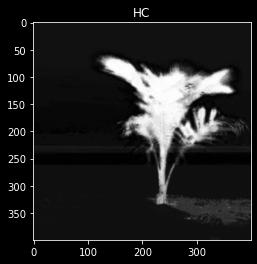

In [4]:
img3_int = cv2.imread("im3.jpg")
img3_float = img3_int.astype(np.float32)
img3_float = img3_float / 255.0

sal = (GetHC(img3_float)*255).astype(np.int32)
import matplotlib.pyplot as plt
plt.figure()
plt.title('HC')
plt.imshow(sal,cmap='gray')
plt.show()

第二题

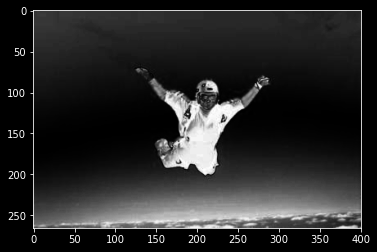

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread("im1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.GaussianBlur(img,(7,7), 0.5)
gray_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

l_mean = np.mean(gray_lab[:,:,0])
a_mean = np.mean(gray_lab[:,:,1])
b_mean = np.mean(gray_lab[:,:,2])
lab = np.square(gray_lab- np.array([l_mean, a_mean, b_mean]))
lab = np.sum(lab,axis=2)
lab = lab/np.max(lab)

plt.imshow(lab, cmap='gray')
plt.show()

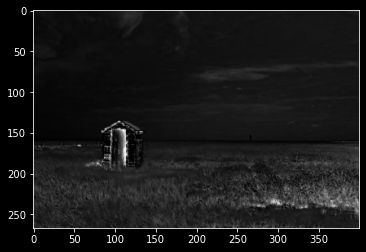

In [6]:
img = cv2.imread("im2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.GaussianBlur(img,(7,7), 0.5)
gray_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

l_mean = np.mean(gray_lab[:,:,0])
a_mean = np.mean(gray_lab[:,:,1])
b_mean = np.mean(gray_lab[:,:,2])
lab = np.square(gray_lab- np.array([l_mean, a_mean, b_mean]))
lab = np.sum(lab,axis=2)
lab = lab/np.max(lab)

plt.imshow(lab, cmap='gray')
plt.show()

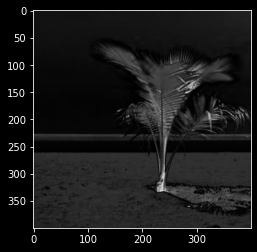

In [7]:
img = cv2.imread("im3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.GaussianBlur(img,(7,7), 0.5)
gray_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

l_mean = np.mean(gray_lab[:,:,0])
a_mean = np.mean(gray_lab[:,:,1])
b_mean = np.mean(gray_lab[:,:,2])
lab = np.square(gray_lab- np.array([l_mean, a_mean, b_mean]))
lab = np.sum(lab,axis=2)
lab = lab/np.max(lab)

plt.imshow(lab, cmap='gray')
plt.show()

[[ 70  70  70 ...  81  81  83]
 [ 70  70  70 ...  81  81  82]
 [ 70  70  70 ...  81  81  80]
 ...
 [244 240 231 ... 170 163 170]
 [215 211 205 ... 165 190 191]
 [205 201 196 ... 187 215 231]]
106.96976543603398


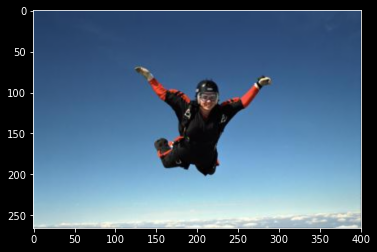

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#读取图片
img = cv2.imread('im1.jpg')
img_lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
m, n, w = img.shape#m行n列

#bgr 转化为 LAB
# img_lab= cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
img_L_mean = np.mean(np.mean(img_lab[:,:,0]))
print(img_lab[:,:,0])
img_a_mean = np.mean(np.mean(img_lab[:,:,1]))
img_b_mean = np.mean(np.mean(img_lab[:,:,2]))
print(img_b_mean)

#高斯滤波
img_R = img[:,:,0]
img_G = img[:,:,1]
img_B = img[:,:,2]

H = np.multiply(cv2.getGaussianKernel(7, 0.5), (cv2.getGaussianKernel(7, 0.5)).T)
img_R_blur = cv2.filter2D(img_R.astype('float32'), -1, H,borderType=cv2.BORDER_CONSTANT)
img_G_blur = cv2.filter2D(img_G.astype('float32'), -1, H,borderType=cv2.BORDER_CONSTANT)
img_B_blur = cv2.filter2D(img_B.astype('float32'), -1, H,borderType=cv2.BORDER_CONSTANT)

img_blur = cv2.merge([img_R_blur,img_G_blur,img_B_blur])

plt.imshow(img_blur.astype('uint8')) # 显示图片
# print(img_blur.astype('uint8')) 
img_lab_blur = cv2.cvtColor(img_blur, cv2.COLOR_RGB2LAB)

[[0.57428551 0.57428551 0.57428551 ... 0.57428551 0.57428551 0.57428551]
 [0.57428551 0.57428551 0.57428551 ... 0.57428551 0.57428551 0.57428551]
 [0.57428551 0.57428551 0.57428551 ... 0.57428551 0.57428551 0.57428551]
 ...
 [0.57428551 0.57428551 0.57428551 ... 0.57428551 0.57428551 0.57428551]
 [0.57428551 0.57428551 0.57428551 ... 0.57428551 0.57428551 0.57428551]
 [0.57428551 0.57428551 0.57428551 ... 0.57428551 0.57428551 0.57428551]]


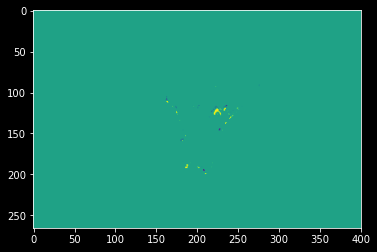

In [9]:
#计算显著图
Sd = np.zeros([m,n])
for i in range(m):
    for j in range(n):
         Sd[i,j] = np.sqrt((img_L_mean - img_lab_blur[i,j,0])**2 + (img_a_mean - img_lab_blur[i,j,1])**2 + (img_b_mean -img_lab_blur[i,j,2])**2)
plt.imshow(Sd)
#归一化
# 归一化子函数
def normalization(data):
    
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
Sd_normalized = normalization(Sd) #调用归一化子函数
print(Sd_normalized)

[[142 145 147 ... 222 221 220]
 [152 152 152 ... 217 217 218]
 [161 160 158 ... 216 218 219]
 ...
 [116  97 112 ... 146 139 148]
 [121 101 111 ... 138 129 139]
 [125 106 111 ... 137 128 138]]
128.96785580524346


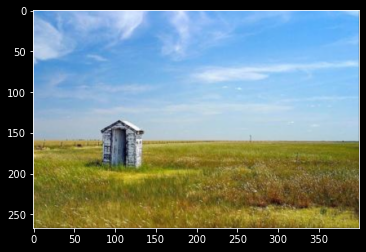

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#读取图片
img = cv2.imread('im2.jpg')
img_lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
m, n, w = img.shape#m行n列

#bgr 转化为 LAB
# img_lab= cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
img_L_mean = np.mean(np.mean(img_lab[:,:,0]))
print(img_lab[:,:,0])
img_a_mean = np.mean(np.mean(img_lab[:,:,1]))
img_b_mean = np.mean(np.mean(img_lab[:,:,2]))
print(img_b_mean)

#高斯滤波
img_R = img[:,:,0]
img_G = img[:,:,1]
img_B = img[:,:,2]

H = np.multiply(cv2.getGaussianKernel(7, 0.5), (cv2.getGaussianKernel(7, 0.5)).T)
img_R_blur = cv2.filter2D(img_R.astype('float32'), -1, H,borderType=cv2.BORDER_CONSTANT)
img_G_blur = cv2.filter2D(img_G.astype('float32'), -1, H,borderType=cv2.BORDER_CONSTANT)
img_B_blur = cv2.filter2D(img_B.astype('float32'), -1, H,borderType=cv2.BORDER_CONSTANT)

img_blur = cv2.merge([img_R_blur,img_G_blur,img_B_blur])

plt.imshow(img_blur.astype('uint8')) # 显示图片
# print(img_blur.astype('uint8')) 
img_lab_blur = cv2.cvtColor(img_blur, cv2.COLOR_RGB2LAB)

C:\Users\20851\AppData\Local\Temp\ipykernel_6560\1205302115.py:12: RuntimeWarning: invalid value encountered in true_divide
  return (data - np.min(data)) / _range


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


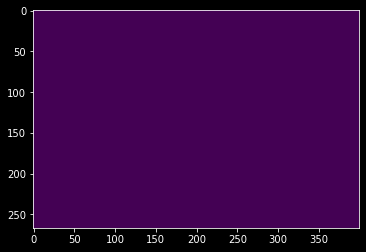

In [11]:
#计算显著图
Sd = np.zeros([m,n])
for i in range(m):
    for j in range(n):
         Sd[i,j] = np.sqrt((img_L_mean - img_lab_blur[i,j,0])**2 + (img_a_mean - img_lab_blur[i,j,1])**2 + (img_b_mean -img_lab_blur[i,j,2])**2)
plt.imshow(Sd)
#归一化
# 归一化子函数
def normalization(data):
    
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
Sd_normalized = normalization(Sd) #调用归一化子函数
print(Sd_normalized)

[[159 159 159 ... 143 143 144]
 [159 159 159 ... 143 143 144]
 [159 159 159 ... 143 143 144]
 ...
 [241 240 239 ... 241 244 246]
 [237 237 237 ... 242 244 244]
 [236 236 236 ... 243 244 244]]
115.58705625


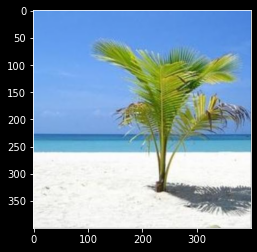

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#读取图片
img = cv2.imread('im3.jpg')
img_lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
m, n, w = img.shape#m行n列

#bgr 转化为 LAB
# img_lab= cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
img_L_mean = np.mean(np.mean(img_lab[:,:,0]))
print(img_lab[:,:,0])
img_a_mean = np.mean(np.mean(img_lab[:,:,1]))
img_b_mean = np.mean(np.mean(img_lab[:,:,2]))
print(img_b_mean)

#高斯滤波
img_R = img[:,:,0]
img_G = img[:,:,1]
img_B = img[:,:,2]

H = np.multiply(cv2.getGaussianKernel(7, 0.5), (cv2.getGaussianKernel(7, 0.5)).T)
img_R_blur = cv2.filter2D(img_R.astype('float32'), -1, H,borderType=cv2.BORDER_CONSTANT)
img_G_blur = cv2.filter2D(img_G.astype('float32'), -1, H,borderType=cv2.BORDER_CONSTANT)
img_B_blur = cv2.filter2D(img_B.astype('float32'), -1, H,borderType=cv2.BORDER_CONSTANT)

img_blur = cv2.merge([img_R_blur,img_G_blur,img_B_blur])

plt.imshow(img_blur.astype('uint8')) # 显示图片
# print(img_blur.astype('uint8')) 
img_lab_blur = cv2.cvtColor(img_blur, cv2.COLOR_RGB2LAB)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


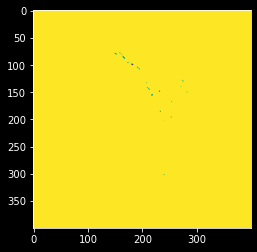

In [13]:
#计算显著图
Sd = np.zeros([m,n])
for i in range(m):
    for j in range(n):
         Sd[i,j] = np.sqrt((img_L_mean - img_lab_blur[i,j,0])**2 + (img_a_mean - img_lab_blur[i,j,1])**2 + (img_b_mean -img_lab_blur[i,j,2])**2)
plt.imshow(Sd)
#归一化
# 归一化子函数
def normalization(data):
    
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
Sd_normalized = normalization(Sd) #调用归一化子函数
print(Sd_normalized)